# M3.2: Comparison of numerical solutions to reference solutions

by Daniel Leitner, Andrea Schnepf 

We compare different numerical codes by solving the benchmarking problems. The following links lead to Jupyter notebooks describing numerical codes implementing Benchmark M3.2:

* [Homegrown Python Code from Schnepf et al. 2018](Xylem flux - Python code.ipynb)
* [Dumux](Xylem flux - Dumux.ipynb)

## Benchmark M3.2(a)

For the comparison save the results in a text file with two lines, containing comma separated depth values [cm] in the first line, and pressure head [cm] in the second line. Locate the file in the folder `/M32a Numerical results/simulatorname`.  

## Benchmark M3.2(b)

For a comparison save the results in a text file with two lines, containing comma separated depth values [cm] in the first line, and pressure head [cm] in the second line. Locate the file in the folder `/M32b Numerical results/simulatorname`.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from math import *
from rsml import * # located in the same directory 

1. DuMuX (b*):
from  -498.4342348369011 to -240.76349069826708  cm pressure head

2. OpenSimRoot (g*):
from  -496.8 to 0.0  cm pressure head

3. RSWMS (r*):
from  -495.488 to -248.025  cm pressure head

4. Reference (m*):
from  -500.0 to -240.0903038863033  cm pressure head

5. SRI.txt (c*):
from  -500.0 to -247.867  cm pressure head

1. DuMuX (b*):
from  -498.1539086391437 to -199.24160614169216  cm pressure head

2. OpenSimRoot (g*):
from  -496.2 to 0.0  cm pressure head

3. RSWMS (r*):
from  -494.764 to -200.085  cm pressure head

4. Reference (m*):
from  -500.0 to -199.19187726413836  cm pressure head



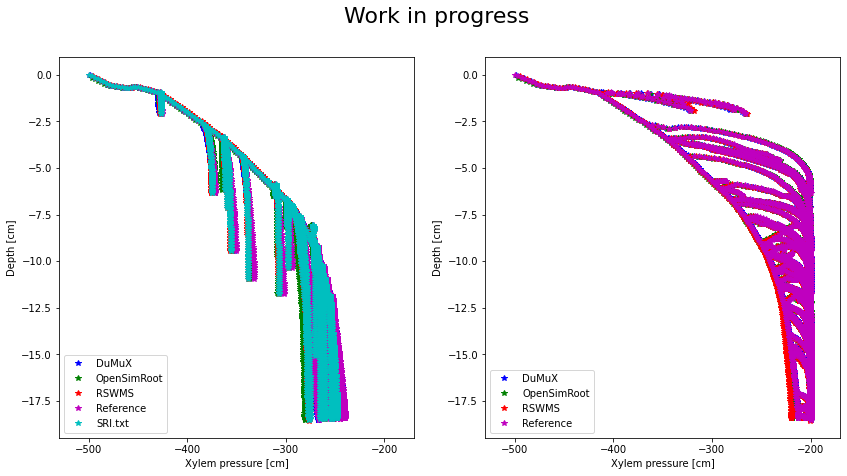

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(14,7)) 
col = ["b*", "g*", "r*", "m*", "c*"]
# M32a
l=[]
for dirname, dirnames, filenames in os.walk('M32a Numerical results/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            l.append(f)
            data = np.loadtxt("M32a Numerical results/"+f,delimiter=',')        
            print(str(i+1)+". "+f+" ("+col[i]+"):")
            print("from ", min(data[1,:]), "to", max(data[1,:]), " cm pressure head\n")        
            pl, = ax[0].plot(data[1,:],data[0,:],col[i])
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)             
ax[0].set_xlabel("Xylem pressure [cm]")  
ax[0].set_ylabel("Depth [cm]")  
ax[0].legend(l)

# M32b
l=[]
for dirname, dirnames, filenames in os.walk('M32b Numerical results/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            l.append(f)
            data = np.loadtxt("M32b Numerical results/"+f,delimiter=',')        
            print(str(i+1)+". "+f+" ("+col[i]+"):")
            print("from ", min(data[1,:]), "to", max(data[1,:]), " cm pressure head\n")        
            #plt.plot(data[1,:],data[0,:],col[i])
            pl, = ax[1].plot(data[1,:],data[0,:],col[i])
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)
 
ax[1].set_xlabel("Xylem pressure [cm]")  
ax[1].set_ylabel("Depth [cm]")
ax[0].set_xlim(-530,-170) 
ax[1].set_xlim(-530,-170)
ax[1].legend(l)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
plt.savefig('m32_results.png', dpi=300, bbox_inches = "tight")
fig.suptitle("Work in progress")
plt.show() 